In [1]:
import os
import glob
import scipy.ndimage
import sklearn.linear_model
import scipy.ndimage.filters

import numpy as np
import pylab as plt

import lemur_util

from lemur_pca import lemur_PCA
from lemur_soar import LemurSOAR


%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 30.0)

NEUTRAL_FACES_GLOB = 'faces/*a*'  # Select all the neutral faces
SMILING_FACES_GLOB = 'faces/*b*'  # Select all the smiling faces

KAGGLE_FACES = 'faces.txt'
N_FEATURES = 3000


# Load neutral faces
neutral = []
for filename in sorted(glob.glob(NEUTRAL_FACES_GLOB)):
  neutral.append(scipy.ndimage.imread(filename, flatten=True).flatten() / 255)
neutral = np.array(neutral)

# Load smiling faces
smiling = []
for filename in sorted(glob.glob(SMILING_FACES_GLOB)):
  smiling.append(scipy.ndimage.imread(filename, flatten=True).flatten() / 255)
smiling = np.array(smiling)

V = lemur_PCA(KAGGLE_FACES, N_FEATURES, 2)

In [2]:
N_REPEAT = 3
N_IMAGES = 200
N_TEST = 50
SPLIT_1 = N_IMAGES - N_TEST
SPLIT_2 = 100 * N_REPEAT

# Shuffle images
p = np.random.permutation(N_IMAGES)

neutral = neutral[p]
smiling = smiling[p]

neutral_training = neutral[:SPLIT_1]# np.append(neutral[:SPLIT_1], smiling[:SPLIT_1], axis=0)
smiling_training = smiling[:SPLIT_1]# np.append(smiling[:SPLIT_1], smiling[:SPLIT_1], axis=0)

neutral_test = neutral[SPLIT_1:]# np.append(neutral[SPLIT_1:], smiling[SPLIT_1:], axis=0)
smiling_test = smiling[SPLIT_1:]# np.append(smiling[SPLIT_1:], smiling[SPLIT_1:], axis=0)

if N_REPEAT > 1:
  neutral_training = lemur_util.distort(np.repeat(neutral_training, N_REPEAT, axis=0), scale=0.05)
  smiling_training = np.repeat(smiling_training, N_REPEAT, axis=0)
  
neutral_training_pca = neutral_training.dot(V)
smiling_training_pca = smiling_training.dot(V)

neutral_test_pca = neutral_test.dot(V)
smiling_test_pca = smiling_test.dot(V)

In [3]:
some_woman = scipy.ndimage.imread('some_woman.jpeg', flatten=True).reshape(1, 9216) / 255
some_guy = scipy.ndimage.imread('some_guy.jpeg', flatten=True).reshape(1, 9216) / 255
obama = scipy.ndimage.imread('obama.jpeg', flatten=True).reshape(1, 9216) / 255
lemur_face = scipy.ndimage.imread('lemur_face.jpeg', flatten=True).reshape(1, 9216) / 255

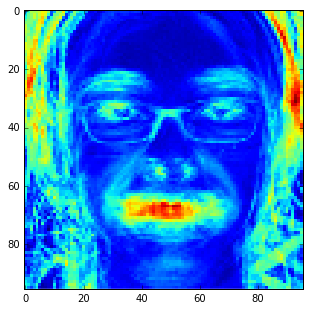

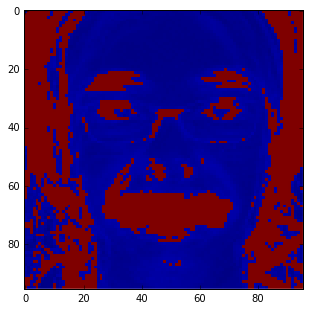

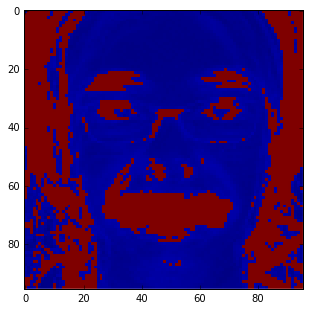

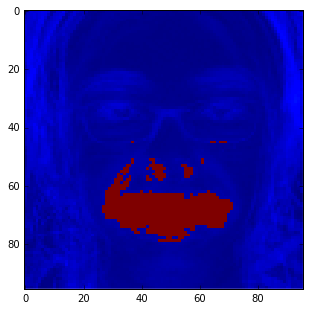

In [4]:
std = np.std(smiling_test - neutral_test, axis=0)

std_selection = np.arange(9216)[std>.1]
rect_selection = np.arange(9216).reshape(96, 96)[45:85,25:75].flatten()

all_indices = range(9216)
indices_selected = set(std_selection).intersection(rect_selection)
indices_unselected = [i  for i in all_indices if i not in indices_selected]
indices_selected = list(indices_selected)

A = std.copy()
A[std_selection] = 2
B = std.copy()
B[std_selection] = 2
C = std.copy()
C[indices_selected] = 2

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(std.reshape(96,96), interpolation='none')
plt.show()
plt.imshow(A.reshape(96,96), interpolation='none')
plt.show()
plt.imshow(B.reshape(96,96), interpolation='none')
plt.show()
plt.imshow(C.reshape(96,96), interpolation='none')
plt.show()
plt.rcParams['figure.figsize'] = (30.0, 30.0)

In [5]:
std = np.std(smiling_test - neutral_test, axis=0)
M = np.ones(9216)
M[indices_selected] = 0

In [6]:
class RidgeRegressionTwist:
  def __init__(self, M, alpha=40):
    self.alpha = alpha
    self.M = M
    
  def fit(self, X, Y):
    self.W = sklearn.linear_model.Ridge(alpha=self.alpha).fit(X, Y - X * self.M )
    return self
  
  def predict(self, X):
    return self.W.predict(X) + X * self.M

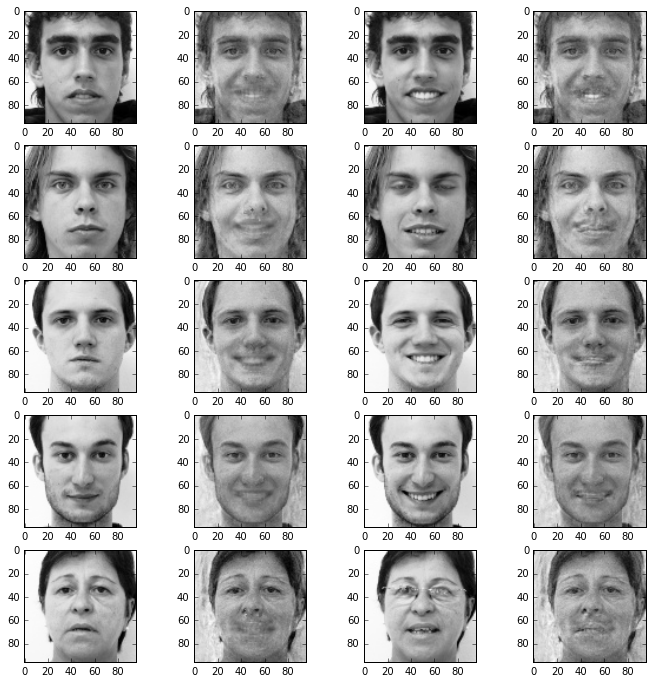

120.837343352 131.113207029


In [7]:
rrt = (RidgeRegressionTwist(M=M, alpha=100)
       .fit(neutral_training, smiling_training)
       .predict(neutral_test))
rrt2 = (RidgeRegressionTwist(M=np.ones(9216))
        .fit(neutral_training, smiling_training)
        .predict(neutral_test))

plt.rcParams['figure.figsize'] = (10.0 / 3 * 3.5, 10.0 / 3 * 3.5)
lemur_util.plot_many(4, neutral_test[-5:], rrt[-5:], smiling_test[-5:], rrt2[-5:])
print lemur_util.L2_squared(rrt - smiling_test) / rrt.shape[0],\
      lemur_util.L2_squared(rrt2 - smiling_test) / rrt.shape[0]
plt.rcParams['figure.figsize'] = (30.0, 30.0)

In [8]:
class RBF:
  def __init__(self, M, sigma=40, alpha=1):
    self.sigma = sigma
    self.alpha = alpha
    self.M = M
  def fit(self, X, Y):
    n, d = X.shape
    self.X = X
    self.W = np.linalg.inv(np.eye(n) + self.alpha * self.dmatrix(X, X)).dot(Y - X * self.M)
    return self
  def predict(self, X):
    return self.dmatrix(X, self.X).dot(self.W) + X * self.M
  def dmatrix(self, X, Y):
    K = np.zeros((Y.shape[0], X.shape[0]))
    for i in range(Y.shape[0]):
      K[i] = np.sum((X - Y[i])**2, axis=1)
    return np.exp(-.5 * K.T / self.sigma)

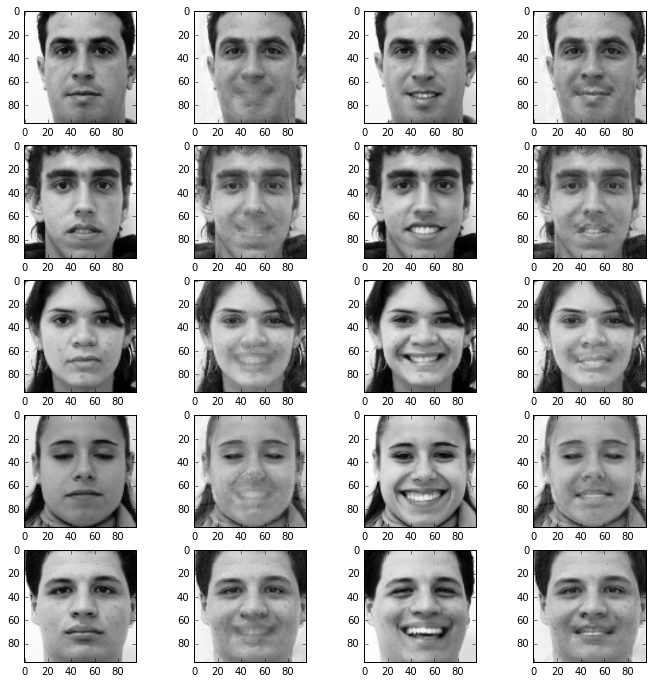

121.805307221 127.3156489


In [9]:
rbf = (RBF(M=M, sigma=800)
       .fit(neutral_training, smiling_training)
       .predict(neutral_test))
rbf2 = (RBF(M=np.ones(9216), sigma=400)
        .fit(neutral_training, smiling_training)
        .predict(neutral_test))

plt.rcParams['figure.figsize'] = (10.0 / 3 * 3.5, 10.0 / 3 * 3.5)
lemur_util.plot_many(4, neutral_test[-5:], rbf[-5:], smiling_test[-5:], rbf2[-5:])
print lemur_util.L2_squared(rbf - smiling_test) / rbf.shape[0],\
      lemur_util.L2_squared(rbf2 - smiling_test) / rbf.shape[0]
plt.rcParams['figure.figsize'] = (30.0, 30.0)

In [10]:
class SOAR:
  def __init__(self, kernel, M, alpha=1, beta=40, n_iters=300, tol=1e-7):
    self.kernel = kernel
    self.alpha = alpha
    self.beta = beta
    self.n_iters = n_iters
    self.tol = tol
    self.M = M

  def fit(self, neutral, smiling):
    self.n, self.d = smiling.shape
    
    self.neutral = neutral
    self.smiling = smiling
    aux_neutral = neutral * self.M

    M = np.linalg.inv(neutral.dot(neutral.T) + self.beta * np.eye(self.n))
    self.W = lemur_util.dot(neutral.T, M, smiling - aux_neutral)
    
    self.kernel.set_x(self.neutral, self.neutral)   # (n, n)
    self.kernel.set_y(self.smiling, self.smiling)   # (n, n)

    self.a = []
    for i in range(self.d):
      self.a.append(np.linalg.inv(self.kernel(i) + self.alpha * np.eye(self.n))
                    .dot(smiling[:,i] - aux_neutral[:,i]))
    
    self.a = np.array(self.a)
    
    return self

  def step(self, Y):
    y = np.zeros(Y.shape)
    self.kernel.set_y(Y, self.smiling)
    for i in range(self.d):
      y[:,i] = self.kernel(i).dot(self.a[i])
    return y

  def predict(self, X):
    aux_X = X * self.M
    Y = X.dot(self.W) + aux_X
    self.kernel.set_x(X, self.neutral)
    for _ in range(self.n_iters):
      Y2 = self.step(Y) + aux_X
      d = lemur_util.L2(Y - Y2)
      if d < self.tol:
        break
      Y = Y2
    return Y
  
  def score(self, X, Y):
    return lemur_util.L2_squared(self.predict(X) - Y) / X.shape[0]


In [11]:
class RBFtL:
  def __init__(self, sigma=400):
    self.sigma = sigma
  def set_x(self, X1, X2):
    self.X = np.exp(-.5 * self._dmatrix(X1, X2) / self.sigma)
  def set_y(self, Y1, Y2):
    self.Y = Y1.dot(Y2.T)
    self.Y1 = Y1.T
    self.Y2 = Y2.T
  def __call__(self, k):
    K = np.outer(self.Y1[k], self.Y2[k])
    return self.X * (self.Y - K)
  def _dmatrix(self, X, Y):
    K = np.zeros((Y.shape[0], X.shape[0]))
    for i in range(Y.shape[0]):
      K[i] = np.sum((X - Y[i])**2, axis=1)
    return K.T

In [12]:
rbftl = (SOAR(RBFtL(), M=M)
         .fit(neutral_training, smiling_training)
         .predict(neutral_test))
rbftl2 = (SOAR(RBFtL(), M=np.ones(9216))
          .fit(neutral_training, smiling_training)
          .predict(neutral_test))

plt.rcParams['figure.figsize'] = (10.0 / 3 * 3.5, 10.0 / 3 * 3.5)
lemur_util.plot_many(4, neutral_test[-5:], rbftl[-5:], smiling_test[-5:], rbftl2[-5:])
print lemur_util.L2_squared(rbftl - smiling_test) / rbftl.shape[0],\
      lemur_util.L2_squared(rbftl2 - smiling_test) / rbftl.shape[0]
plt.rcParams['figure.figsize'] = (30.0, 30.0)

KeyboardInterrupt: 

In [14]:
class SelectionAware:
  def __init__(self, selected):
    self.selected = set(selected)
  def set_x(self, X1, X2):
    self.X = X1.dot(X2.T) + 1
    self.X1 = X1.T
    self.X2 = X2.T
  def set_y(self, Y1, Y2):
    self.Y = Y1.dot(Y2.T)
    self.Y1 = Y1.T
    self.Y2 = Y2.T
  def __call__(self, k):
    if k in self.selected:
      return self.X + self.Y - np.outer(self.Y1[k], self.Y2[k])
    return np.outer(self.X1[k], self.X2[k]) + 1

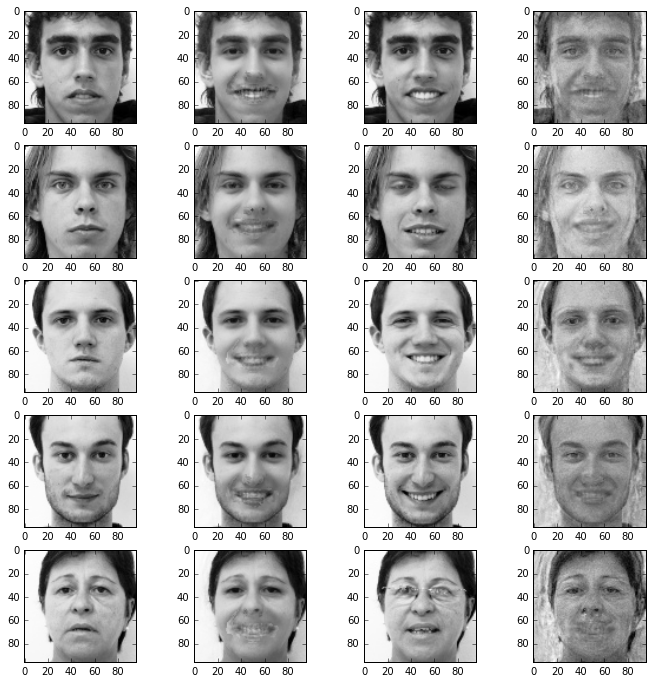

95.7991626367 180.498699937


In [15]:
sa = (SOAR(SelectionAware(indices_selected), M=np.zeros(9216))
         .fit(neutral_training, smiling_training)
         .predict(neutral_test))
sa2 = (SOAR(SelectionAware(all_indices), M=M)
          .fit(neutral_training, smiling_training)
          .predict(neutral_test))

plt.rcParams['figure.figsize'] = (10.0 / 3 * 3.5, 10.0 / 3 * 3.5)
lemur_util.plot_many(4, neutral_test[-5:], sa[-5:], smiling_test[-5:], sa2[-5:])
print lemur_util.L2_squared(sa - smiling_test) / sa.shape[0],\
      lemur_util.L2_squared(sa2 - smiling_test) / sa.shape[0]
plt.rcParams['figure.figsize'] = (30.0, 30.0)

In [75]:
class LpL:
  def set_x(self, X1, X2):
    self.X = X1.dot(X2.T)
  def set_y(self, Y1, Y2):
    self.Y = Y1.dot(Y2.T)
    self.Y1 = Y1.T
    self.Y2 = Y2.T
  def __call__(self, k):
    return self.X + self.Y - np.outer(self.Y1[k], self.Y2[k])

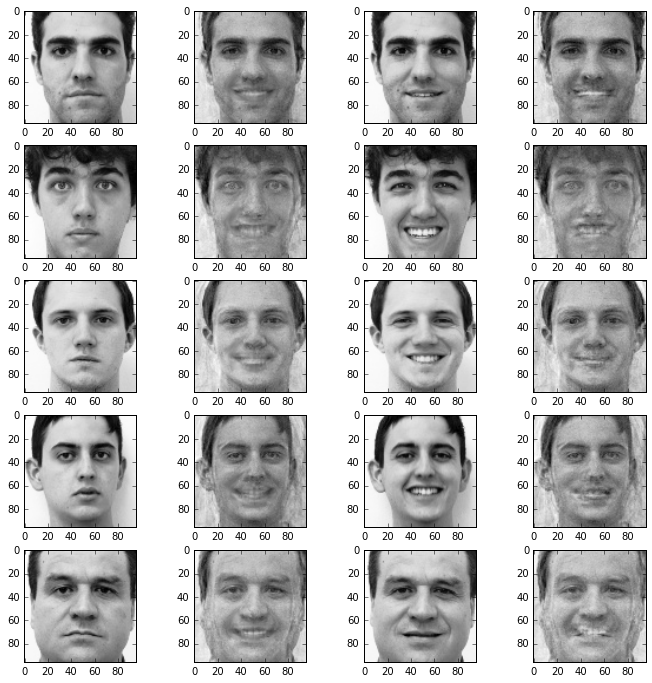

161.277177193 191.311465378


In [79]:
lpl = (SOAR(LpL(), M=M, alpha=40, beta=100)
       .fit(neutral_training, smiling_training)
       .predict(neutral_test))
lpl2 = (SOAR(LpL(), M=np.ones(9216))
        .fit(neutral_training, smiling_training)
        .predict(neutral_test))

plt.rcParams['figure.figsize'] = (10.0 / 3 * 3.5, 10.0 / 3 * 3.5)
lemur_util.plot_many(4, neutral_test[-5:], lpl[-5:], smiling_test[-5:], lpl2[-5:])
print lemur_util.L2_squared(lpl - smiling_test) / lpl.shape[0],\
      lemur_util.L2_squared(lpl2 - smiling_test) / lpl.shape[0]
plt.rcParams['figure.figsize'] = (30.0, 30.0)

In [ ]:
rbf = RBF(sigma=40).fit(neutral_training_pca, smiling_training_pca - neutral_training_pca)
rbf_prediction = (rbf.predict(neutral_test_pca) + neutral_test_pca).dot(V.T)

rbftl = SOAR(RBFtL(sigma=40)).fit(neutral_training_pca, smiling_training_pca)
rbftl_prediction = rbftl.predict(neutral_test_pca).dot(V.T)

lemur_util.plot_many(4, neutral_test, rbf_prediction, smiling_test, rbftl_prediction)

In [217]:
print lemur_util.L2_squared(rrt - smiling_test) / rrt.shape[0], lemur_util.L2_squared(rrt2 - smiling_test)

117.69848794 629.60317519


In [ ]:
class Ensemble:
  def __init__(self, model_a, model_b):
    self.model_a = model_a
    self.model_b = model_b

  def fit(self, X, Y):
    d = 9216
    
    Y = Y.dot(V.T).T
    Y_a = lemur_util.normalize(self.model_a.predict(X).dot(V.T)).T
    Y_b = lemur_util.normalize(self.model_b.predict(X).dot(V.T)).T
    
    alpha = np.zeros(d)
    for i in range(d):
      t_1 = Y_a[i] - Y_b[i]
      t_2 = Y[i] - Y_b[i]
      alpha[i] = t_2.dot(t_1) / t_1.dot(t_1)
      
    self.alpha = np.diag(alpha)
    self.beta = np.eye(d) - self.alpha

    return self
  
  def predict(self, X):
    Y_a = lemur_util.normalize(self.model_a.predict(X).dot(V.T))
    Y_b = lemur_util.normalize(self.model_b.predict(X).dot(V.T))
    return Y_a.dot(self.alpha) + Y_b.dot(self.beta)
  
rr_ensemble = sklearn.linear_model.Ridge().fit(neutral_training_2a, smiling_training_2a)
rrt_ensemble = RidgeRegressionTwist(40).fit(neutral_training_2a, smiling_training_2a)
ensemble = Ensemble(rr_ensemble, rrt_ensemble).fit(neutral_training_2b, smiling_training_2b)

ensemble_predictions = lemur_util.normalize(ensemble.predict(neutral_test_pca_2))
rr2 = lemur_util.normalize(rr_ensemble.predict(neutral_test_pca_2).dot(V.T))
rrt2 = lemur_util.normalize(rrt_ensemble.predict(neutral_test_pca_2).dot(V.T))

In [ ]:
class LinearPlusLinear:
  def __init__(self, r1=35, r2=1):
    self.r1 = r1
    self.r2 = r2
    
  def fit(self, X, Y):
    X = X.T
    Y = Y.T
    
    d, n = X.shape
    I_d = np.eye(d)
    U = np.zeros((d, d))
    V = np.zeros((d, d))
    
    M = np.eye(n) + X.T.dot(X) / self.r1 + Y.T.dot(Y) / self.r2
    for i in range(d):
      alpha = np.linalg.inv(M - np.outer(Y[i], Y[i])).dot(Y[i] - X[i])
      beta = -Y[i].dot(alpha)
      U[i] = X.dot(alpha) / self.r1
      V[i] = (Y.dot(alpha) + beta * I_d[i]) / self.r2
      
    W = V.T - I_d
    self.W = (U.T + I_d).dot(-W.T).dot(np.linalg.inv(W.dot(W.T)))
    
    return self
 
  def predict(self, X):
    return X.dot(self.W)
  
lpl_predictions, lpl_score = lemur_util.evaluate(neutral_training_pca, smiling_training_pca, neutral_test_pca,
                                                 smiling_test_pca, LinearPlusLinear())
lpl = lemur_util.normalize(lpl_predictions.dot(V.T))

In [ ]:
class KernelPlusLinear:
  def __init__(self, X, Y, kernel, r1=.1, r2=1):
    n, d = X.shape
    Y = Y.T
    I_d = np.eye(d)
    M = np.eye(n) + kernel(X, X) / r1 + Y.T.dot(Y) / r2
    U = np.zeros((d, n))
    V = np.zeros((d, d))
    for i in range(d):
      alpha = np.linalg.inv(M - np.outer(Y[i], Y[i]) / r2).dot(Y[i])
      beta = -Y[i].dot(alpha)
      U[i] = alpha / r1
      V[i] = (Y.dot(alpha) + beta * I_d[i]) / r2
    W = V.T - I_d
    self.W = -W.T.dot(np.linalg.inv(W.dot(W.T)))
    self.k = kernel
    self.X = X
    self.U = U.T
  def predict(self, X):
    X = self.k(X, self.X).dot(self.U)
    return X.dot(self.W)